# Modelos predictivos.

## Importación de librerias a utilizar y configuración para la presentación de resultados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Importación del dataset

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
y_train = y_train.values.ravel()
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')
y_val = y_val.values.ravel()
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
y_test = y_test.values.ravel()

## Elección de métricas para evaluación de modelos de aprendizaje de máquina.

#### Para evaluar y comparar diferentes modelos, se opta por usar las siguientes métricas: 
#### 1- F1-Score: esta métrica brinda un equilibrio entre la precision y el recall, es decir que ayudara a minimizar tanto los falsos positivos como los falsos negativos.

## Entrenamiento de Modelos

### 1- Regresión logística

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_recall_curve, f1_score

lr = LogisticRegression(solver='saga', max_iter=10000)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'class_weight': ['balanced', None],
    'l1_ratio' : [0.1, 0.5, 0.7]
}

grid_lr = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)

c:\Users\herna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'l1_ratio': [0.1, 0.5, 0.7],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1')

In [4]:
# Mejor modelo
best_lr = grid_lr.best_estimator_
best_lr

LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.1,
                   max_iter=10000, penalty='l1', solver='saga')

In [5]:
# Predicciones en los datos de entrenamiento
y_pred_train = best_lr.predict(X_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

F1 Score de entrenamiento: 0.0000


In [6]:
# Predicciones en los datos de validación
y_pred_val = best_lr.predict(X_val) 
val_f1_lr = f1_score(y_val, y_pred_val) 
print(f"F1 Score de validacion: {val_f1_lr:.4f}")

F1 Score de validacion: 0.0000


#### Se observa una f1-score bastante por debajo de la obtenida con los datos de entrenamiento, por lo que se procede a ajustar el umbral de clasificación para los datos.

In [7]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = best_lr.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Calcular F1-score para cada umbral con verificación de valores cero
f1_scores = []
for p, r in zip(precision[:-1], recall[:-1]):
    if (p + r) > 0:  # Evitar la división por cero
        f1_scores.append(2 * (p * r) / (p + r))
    else:
        f1_scores.append(0)  # Establecer F1-score a 0 si precision y recall son 0

# Encontrar el umbral que maximiza el F1-score
best_threshold_lr = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para el F1-score: {best_threshold_lr:.4f}")


Mejor umbral para el F1-score: 0.4207


**Fuente del código:** Microsoft Copilot. (2025). Código para encontrar el umbral que maximize el valor del f1-score en funcion de la precisión y el recall. Generado con la asistencia de Microsoft Copilot.

In [8]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_lr).astype(int) 
adjusted_f1_lr = f1_score(y_val, y_pred_adjusted) 
print(f"F1-score ajustado: {adjusted_f1_lr:.4f}")

F1-score ajustado: 0.0695


In [9]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_lr = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_lr:.4f}")

AUC Score: 0.4322


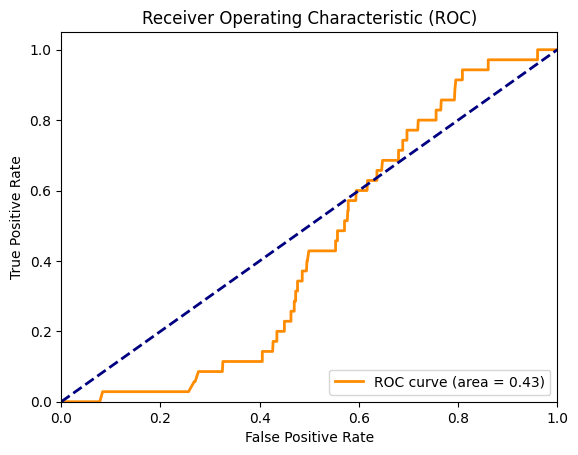

In [10]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Función para imprimir la matriz de confusión
def print_confusion_matrix(confusion_matrix, f1):
  import seaborn as sn
  plt.figure(figsize=(10,7))
  sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion matrix. F1-score={}'.format(f1))
  plt.show()

**Fuente del código:** Curso: Fundamentos de Aprendizaje de Máquina - Semana 5 - Taller 5 (Diplomatura de Especialización en Data Analytics - PUCP - 2024)

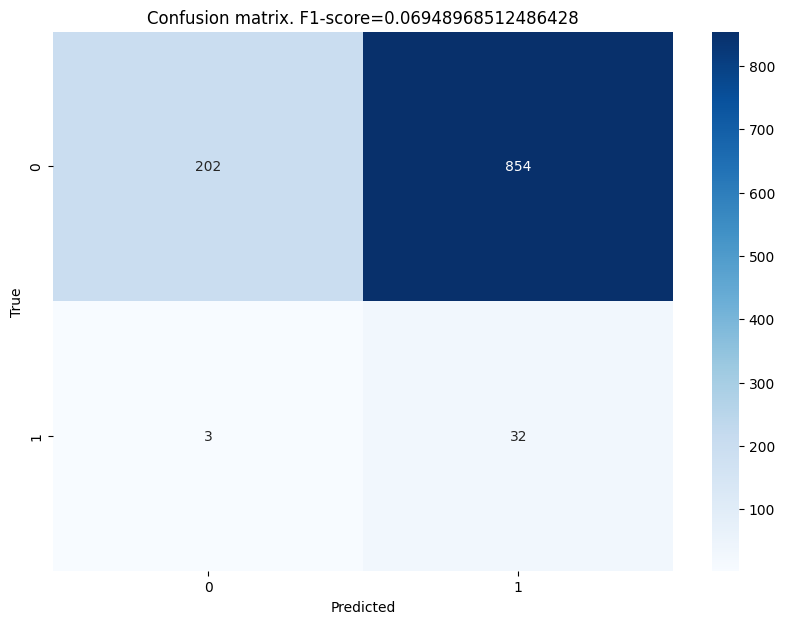

In [12]:
# Matriz de confusión para los datos de validación ajustados
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_f1_lr)

### 2- Árboles de decisión

In [13]:
# Entrenamiento del modelo de árbol de decisión
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

max_depth = list(range(1,7))
min_samples_split = list(range(2,15))
min_samples_leaf = list(range(1,9))
criterion = ['gini', 'entropy']
max_features = [None, 'sqrt', 'log2']

param_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion': criterion,
    'max_features': max_features
}

grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='f1', cv = 5)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14]},
             scoring='f1')

In [14]:
# Mejores parámetros
grid_dt.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [15]:
# Mejor modelo
best_dt = grid_dt.best_estimator_
best_dt

DecisionTreeClassifier(max_depth=6, min_samples_split=5)

In [16]:
# Predicciones en los datos de entrenamiento
y_pred_train = best_dt.predict(X_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

F1 Score de entrenamiento: 0.9419


In [17]:
# Predicciones en los datos de validación
y_pred_val = best_dt.predict(X_val) 
val_f1_dt = f1_score(y_val, y_pred_val) 
print(f"F1 Score de validacion: {val_f1_dt:.4f}")

F1 Score de validacion: 0.3114


In [18]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = best_dt.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Calcular F1-score para cada umbral con verificación de valores cero
f1_scores = []
for p, r in zip(precision[:-1], recall[:-1]):
    if (p + r) > 0:  # Evitar la división por cero
        f1_scores.append(2 * (p * r) / (p + r))
    else:
        f1_scores.append(0)  # Establecer F1-score a 0 si precision y recall son 0

# Encontrar el umbral que maximiza el F1-score
best_threshold_dt = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para el F1-score: {best_threshold_dt:.4f}")

Mejor umbral para el F1-score: 0.7797


In [19]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_dt).astype(int) 
adjusted_f1_dt = f1_score(y_val, y_pred_adjusted) 
print(f"F1-score ajustado: {adjusted_f1_dt:.4f}")

F1-score ajustado: 0.3307


In [20]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_dt = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_dt:.4f}")

AUC Score: 0.8573


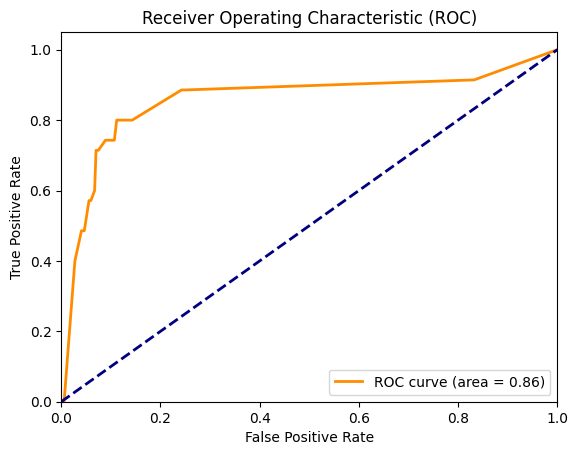

In [21]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

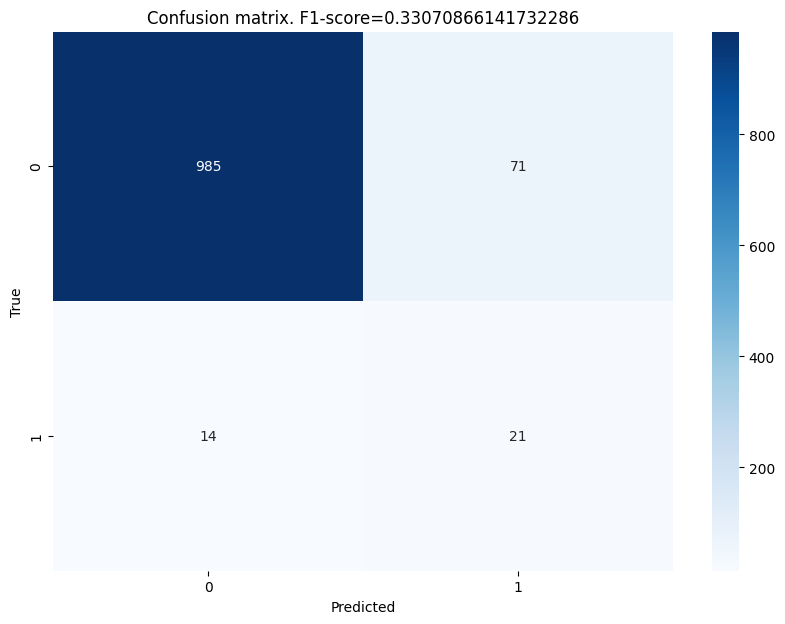

In [22]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_f1_dt)

### 3- Bosque aleatorio

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
n_estimators = [50, 100, 200]
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2']
max_depth = [None, 10, 15, 20]

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterion,
    'max_features': max_features
}
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv = 5, n_jobs=-1)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [24]:
# Mejores parámetros
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [25]:
# Mejor modelo
best_rf = grid_rf.best_estimator_
best_rf

RandomForestClassifier(max_depth=15, random_state=42)

In [26]:
# Predicciones en los datos de entrenamiento
y_pred_train = best_rf.predict(X_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

F1 Score de entrenamiento: 0.9974


In [27]:
# Predicciones en los datos de validación
y_pred_val = best_rf.predict(X_val) 
val_f1_rf = f1_score(y_val, y_pred_val) 
print(f"F1 Score de validacion: {val_f1_rf:.4f}")

F1 Score de validacion: 0.3913


In [28]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = best_rf.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Calcular F1-score para cada umbral con verificación de valores cero
f1_scores = []
for p, r in zip(precision[:-1], recall[:-1]):
    if (p + r) > 0:  # Evitar la división por cero
        f1_scores.append(2 * (p * r) / (p + r))
    else:
        f1_scores.append(0)  # Establecer F1-score a 0 si precision y recall son 0

# Encontrar el umbral que maximiza el F1-score
best_threshold_rf = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para el F1-score: {best_threshold_rf:.4f}")

Mejor umbral para el F1-score: 0.6009


In [29]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_rf).astype(int) 
adjusted_f1_rf = f1_score(y_val, y_pred_adjusted)
print(f"F1-score ajustado: {adjusted_f1_rf:.4f}")

F1-score ajustado: 0.4074


In [30]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_rf = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_rf:.4f}")

AUC Score: 0.9316


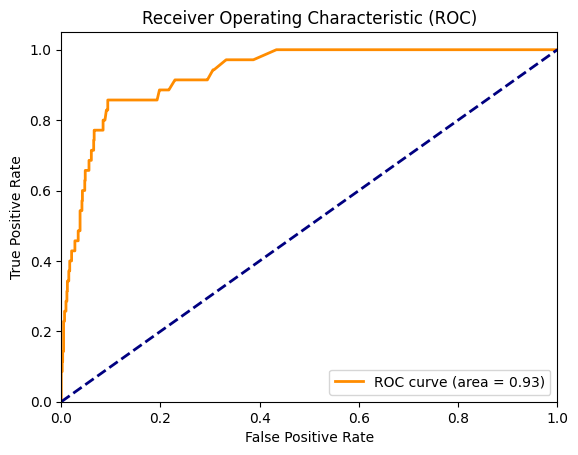

In [31]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

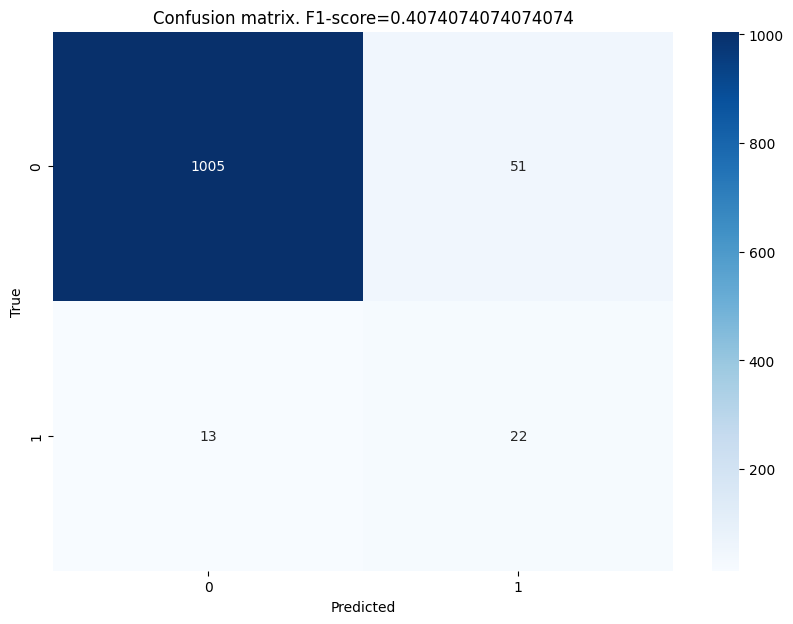

In [32]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_f1_rf)

### 4- Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3, 5]
}

grid_gb = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [34]:
grid_gb.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [35]:
# Mejor modelo
gb_clf = grid_gb.best_estimator_
gb_clf

GradientBoostingClassifier(max_depth=7, min_samples_leaf=3, n_estimators=300,
                           random_state=42)

In [36]:
# Predicciones en los datos de entrenamiento
y_pred_train = gb_clf.predict(X_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

F1 Score de entrenamiento: 1.0000


In [37]:
# Predicciones en los datos de validación
y_pred_val = gb_clf.predict(X_val) 
val_f1_gb = f1_score(y_val, y_pred_val) 
print(f"F1 Score de validacion: {val_f1_gb:.4f}")

F1 Score de validacion: 0.4107


In [38]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = gb_clf.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Calcular F1-score para cada umbral con verificación de valores cero
f1_scores = []
for p, r in zip(precision[:-1], recall[:-1]):
    if (p + r) > 0:  # Evitar la división por cero
        f1_scores.append(2 * (p * r) / (p + r))
    else:
        f1_scores.append(0)  # Establecer F1-score a 0 si precision y recall son 0

# Encontrar el umbral que maximiza el F1-score
best_threshold_gb = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para el F1-score: {best_threshold_gb:.4f}")

Mejor umbral para el F1-score: 0.6972


In [39]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_gb).astype(int) 
adjusted_f1_gb = f1_score(y_val, y_pred_adjusted) 
print(f"F1-score ajustado: {adjusted_f1_gb:.4f}")

F1-score ajustado: 0.4242


In [40]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_gb = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_gb:.4f}")

AUC Score: 0.9200


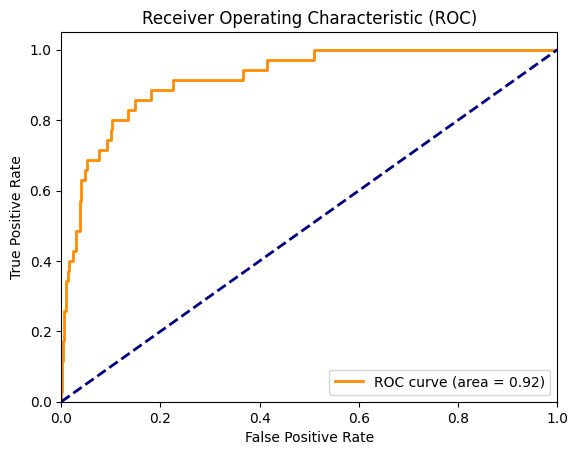

In [41]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

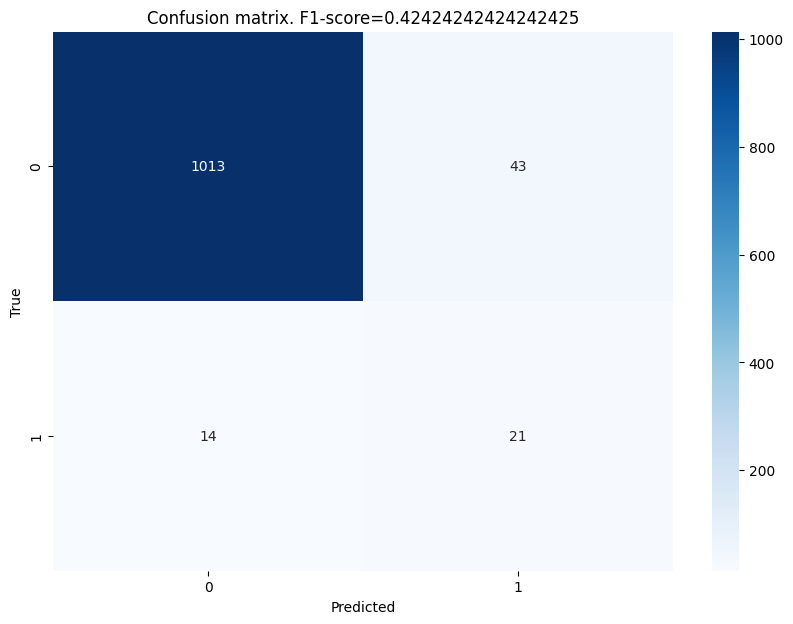

In [42]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_f1_gb)

### 5- KNeighbors Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'p': [1, 2]
}

grid_knn = GridSearchCV(estimator=knn_clf, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 30, 40], 'n_neighbors': [3, 5, 7, 9],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='f1')

In [44]:
grid_knn.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'n_neighbors': 9,
 'p': 1,
 'weights': 'uniform'}

In [45]:
# Mejor modelo
best_knn = grid_knn.best_estimator_
best_knn

KNeighborsClassifier(leaf_size=20, n_neighbors=9, p=1)

In [46]:
# Predicciones en los datos de entrenamiento
y_pred_train = best_knn.predict(X_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

F1 Score de entrenamiento: 0.7963


In [47]:
# Predicciones en los datos de validación
y_pred_val = best_knn.predict(X_val) 
val_f1_knn = f1_score(y_val, y_pred_val) 
print(f"F1 Score de validacion: {val_f1_knn:.4f}")

F1 Score de validacion: 0.1385


In [48]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = best_knn.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Calcular F1-score para cada umbral con verificación de valores cero
f1_scores = []
for p, r in zip(precision[:-1], recall[:-1]):
    if (p + r) > 0:  # Evitar la división por cero
        f1_scores.append(2 * (p * r) / (p + r))
    else:
        f1_scores.append(0)  # Establecer F1-score a 0 si precision y recall son 0

# Encontrar el umbral que maximiza el F1-score
best_threshold_knn = thresholds[np.argmax(f1_scores)]
print(f"Mejor umbral para el F1-score: {best_threshold_knn:.4f}")

Mejor umbral para el F1-score: 0.5556


In [49]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_knn).astype(int) 
adjusted_f1_knn = f1_score(y_val, y_pred_adjusted) 
print(f"F1-score ajustado: {adjusted_f1_knn:.4f}")

F1-score ajustado: 0.1145


In [50]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_knn = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_knn:.4f}")

AUC Score: 0.7362


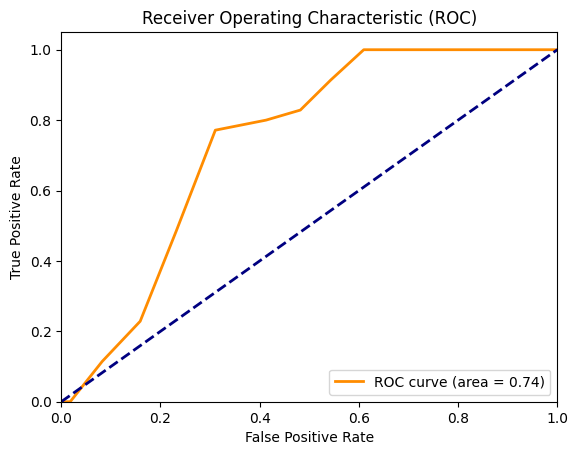

In [51]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

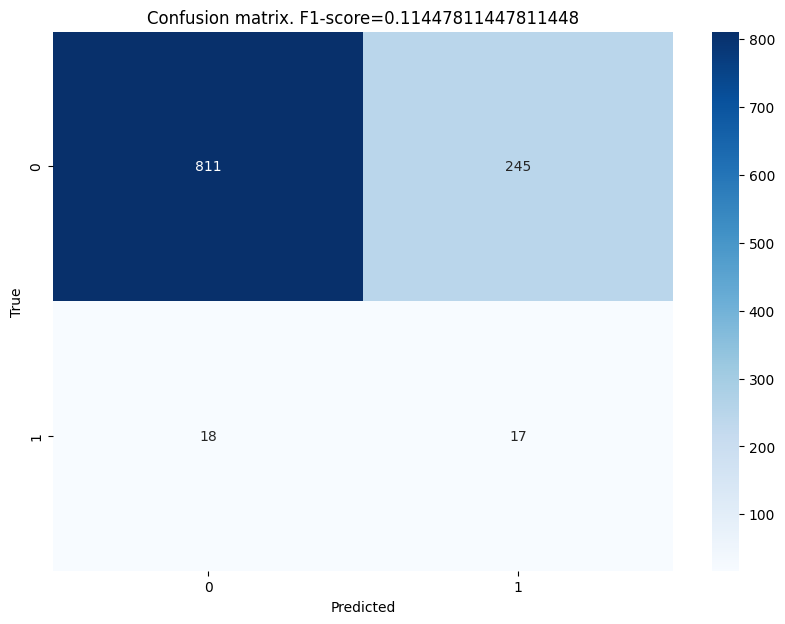

In [52]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_f1_knn)

## Comparación de resultados - Validación

In [53]:
modelos = ['Regresion Lineal', 'Arbol de decision', 'Bosque aleaotorio', 'Gradient Boosting', 'KNN']
precision = [val_f1_lr, val_f1_dt, val_f1_rf, val_f1_gb, val_f1_knn]
umbrales = [best_threshold_lr, best_threshold_dt, best_threshold_rf, best_threshold_gb, best_threshold_knn]
precision_ajustada = [adjusted_f1_lr, adjusted_f1_dt, adjusted_f1_rf, adjusted_f1_gb, adjusted_f1_knn]
auc = [auc_score_lr, auc_score_dt, auc_score_rf, auc_score_gb, auc_score_knn]

validacion_comparativa = pd.DataFrame({
    'Modelo': modelos,
    'F1': precision,
    'Umbral': umbrales,
    'F1 Ajustado': precision_ajustada,
    'AUC': auc
})

validacion_comparativa


,Modelo,F1,Umbral,F1 Ajustado,AUC
0,Regresion Lineal,0.000000,0.420691,0.069490,0.432238
1,Arbol de decision,0.311377,0.779661,0.330709,0.857305
2,Bosque aleaotorio,0.391304,0.600909,0.407407,0.931602
3,Gradient Boosting,0.410714,0.697162,0.424242,0.919968
4,KNN,0.138462,0.555556,0.114478,0.736161


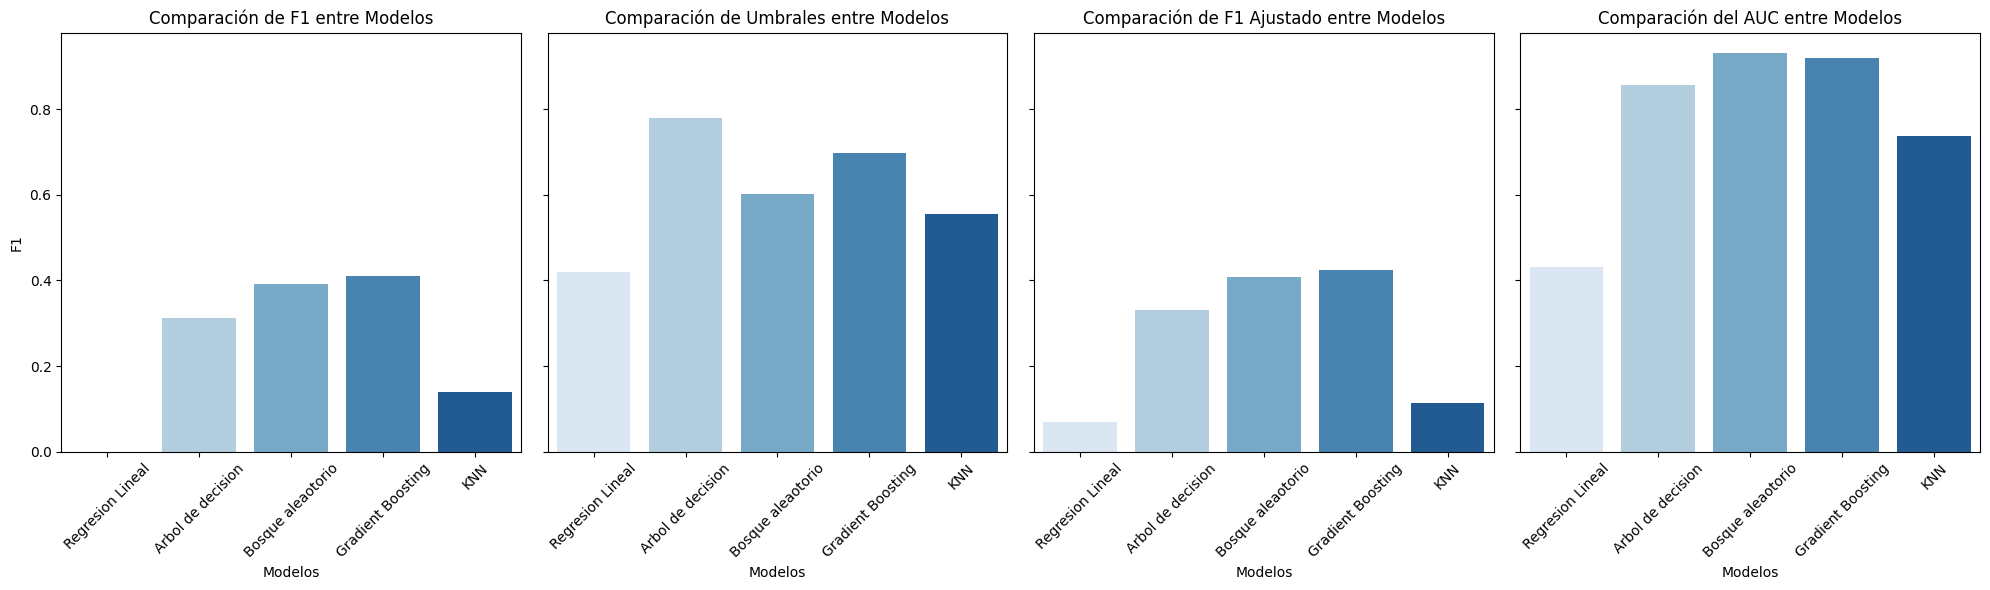

In [54]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

# Comparacion de la precisión en los datos de validacion
sns.barplot(ax=axes[0], x='Modelo', y='F1', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[0].set_title('Comparación de F1 entre Modelos')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('F1')
axes[0].tick_params(axis='x', rotation=45)

# Comparacion de umbrales optimos
sns.barplot(ax=axes[1], x='Modelo', y='Umbral', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[1].set_title('Comparación de Umbrales entre Modelos')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Umbral')
axes[1].tick_params(axis='x', rotation=45)

# Comparacion de la precisión ajustada en los datos validacion
sns.barplot(ax=axes[2], x='Modelo', y='F1 Ajustado', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[2].set_title('Comparación de F1 Ajustado entre Modelos')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('F1 Ajustado')
axes[2].tick_params(axis='x', rotation=45)

# Comparacion del AUC score en los datos de validacion
sns.barplot(ax=axes[3], x='Modelo', y='AUC', hue='Modelo',data=validacion_comparativa, palette='Blues')
axes[3].set_title('Comparación del AUC entre Modelos')
axes[3].set_xlabel('Modelos')
axes[3].set_ylabel('AUC')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Reporte de Resultados - Conjunto de prueba

### 1- Regresión Logística

In [55]:
# Predicciones en los datos de prueba
y_pred_test = best_lr.predict(X_test) 
test_f1_lr = f1_score(y_test, y_pred_test) 
print(f"F1 Score de prueba: {test_f1_lr:.4f}")

F1 Score de prueba: 0.0000


In [56]:
# F1 ajustado con el umbral óptimo del conjunto de validación
y_pred_proba = best_lr.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_lr).astype(int) 
adjusted_f1_test_lr = f1_score(y_test, y_pred_adjusted) 
print(f"F1 ajustado: {adjusted_f1_test_lr:.4f}")

F1 ajustado: 0.0693


In [57]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_lr = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_lr:.4f}")

AUC Score: 0.4830


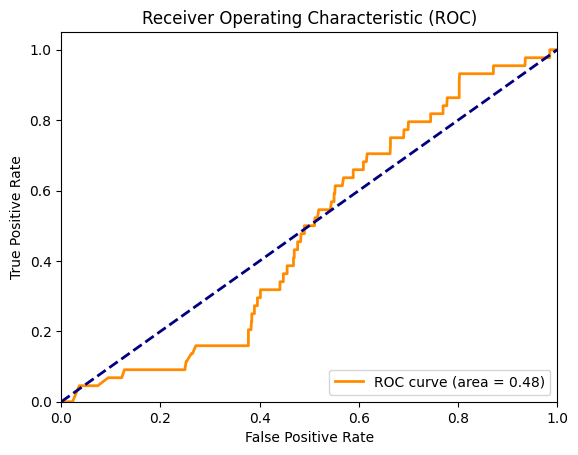

In [58]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

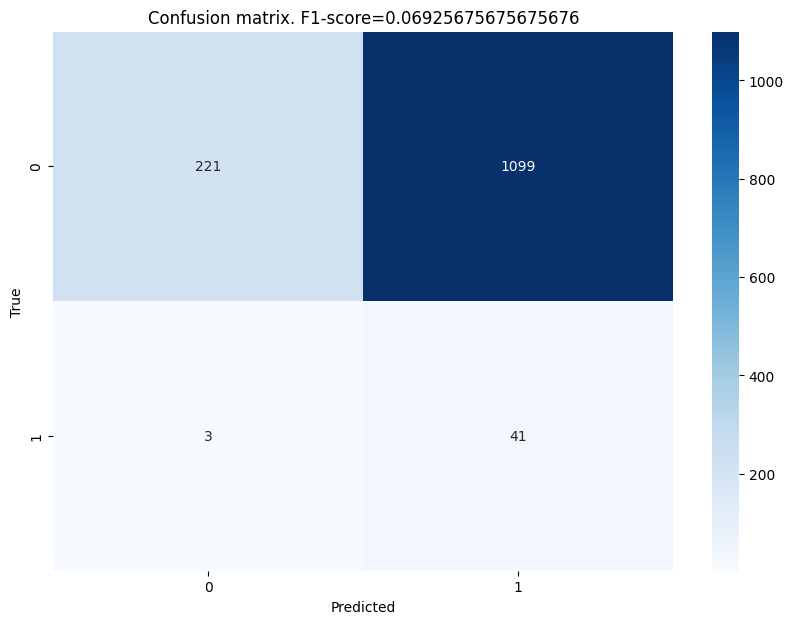

In [59]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_f1_test_lr)

### 2- Árbol de decisión

In [60]:
# Predicciones en los datos de prueba
y_pred_test = best_dt.predict(X_test) 
test_f1_dt = f1_score(y_test, y_pred_test) 
print(f"F1 Score de prueba: {test_f1_dt:.4f}")

F1 Score de prueba: 0.3367


In [61]:
# F1 ajustado con el umbral óptimo del conjunto de validación
y_pred_proba = best_dt.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_dt).astype(int) 
adjusted_f1_test_dt = f1_score(y_test, y_pred_adjusted) 
print(f"F1 ajustado: {adjusted_f1_test_dt:.4f}")

F1 ajustado: 0.3613


In [62]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_dt = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_dt:.4f}")

AUC Score: 0.8361


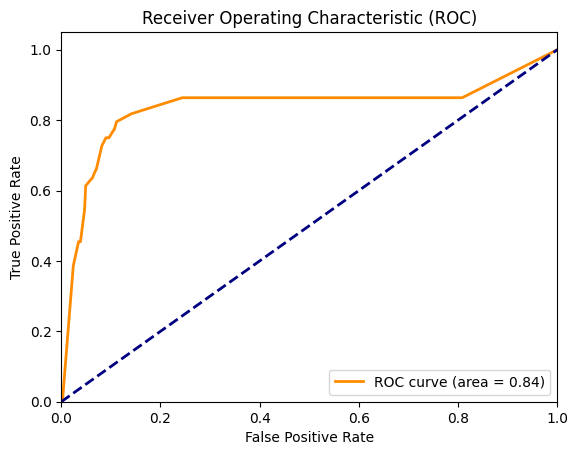

In [63]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

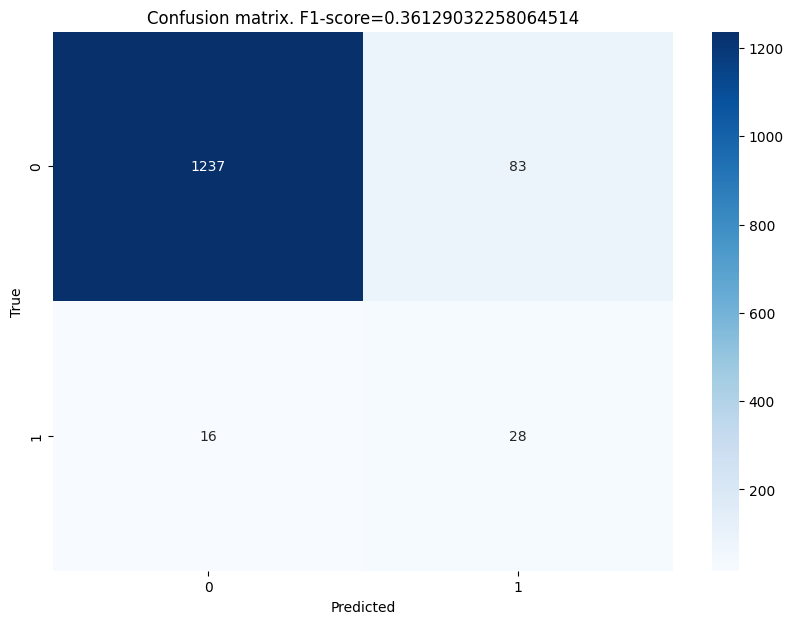

In [64]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_f1_test_dt)

### 3- Bosque aleatorio

In [65]:
# Predicciones en los datos de prueba
y_pred_test = best_rf.predict(X_test) 
test_f1_rf = f1_score(y_test, y_pred_test) 
print(f"F1 Score de prueba: {test_f1_rf:.4f}")

F1 Score de prueba: 0.3952


In [66]:
# F1 ajustado con el umbral óptimo del conjunto de validación
y_pred_proba = best_rf.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_rf).astype(int) 
adjusted_f1_test_rf = f1_score(y_test, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_f1_test_rf:.4f}")

Precision ajustada: 0.3942


In [67]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_rf = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_rf:.4f}")

AUC Score: 0.9399


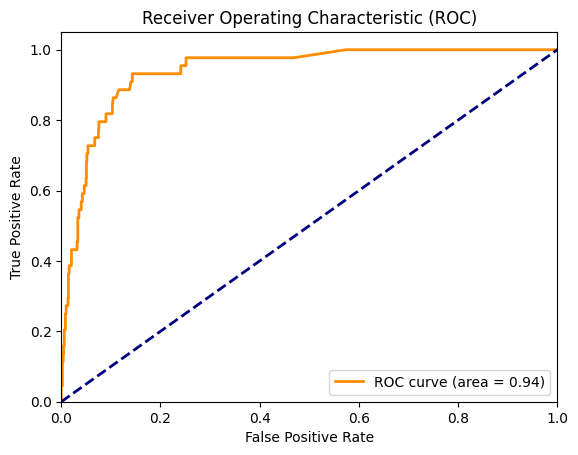

In [68]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

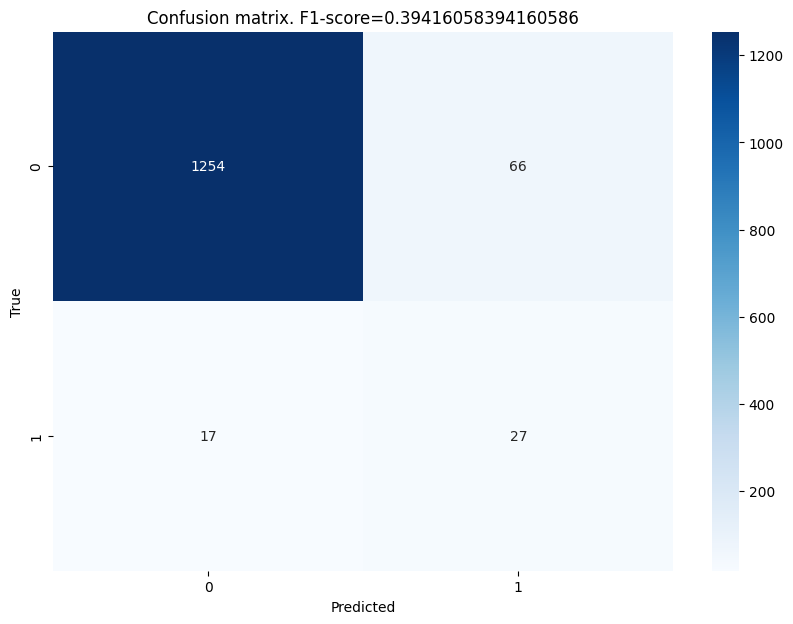

In [69]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_f1_test_rf)

### 4- Gradient Boosting

In [70]:
# Predicciones en los datos de prueba
y_pred_test = gb_clf.predict(X_test) 
test_f1_gb = f1_score(y_test, y_pred_test) 
print(f"F1 Score de prueba: {test_f1_gb:.4f}")

F1 Score de prueba: 0.4552


In [71]:
# F1 ajustado con el umbral óptimo del conjunto de validación
y_pred_proba = gb_clf.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_gb).astype(int) 
adjusted_f1_test_gb = f1_score(y_test, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_f1_test_gb:.4f}")

Precision ajustada: 0.4531


In [72]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_gb = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_gb:.4f}")

AUC Score: 0.9416


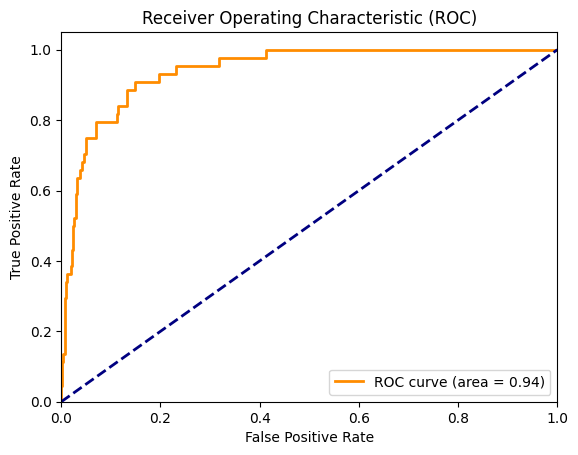

In [73]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

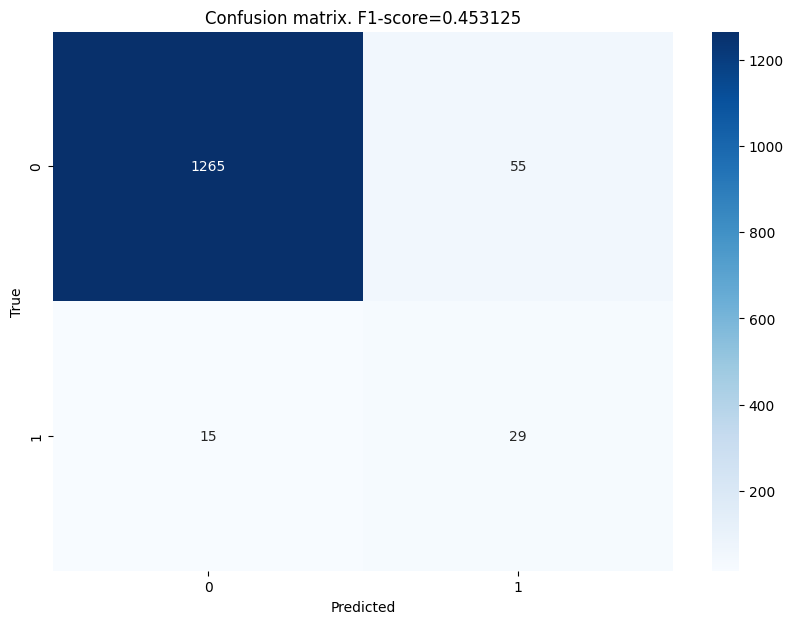

In [74]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_f1_test_gb)

### 5- KNeighbors Classifier

In [75]:
# Predicciones en los datos de prueba
y_pred_test = best_knn.predict(X_test) 
test_f1_knn = f1_score(y_test, y_pred_test) 
print(f"F1 Score de prueba: {test_f1_knn:.4f}")

F1 Score de prueba: 0.0958


In [76]:
# F1 ajustado con el umbral óptimo del conjunto de validación
y_pred_proba = best_knn.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_knn).astype(int) 
adjusted_f1_test_knn = f1_score(y_test, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_f1_test_knn:.4f}")

Precision ajustada: 0.1193


In [77]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score__test_knn = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score__test_knn:.4f}")

AUC Score: 0.7108


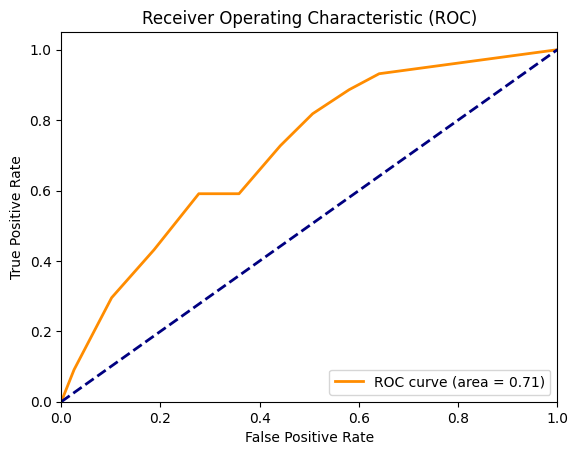

In [78]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score__test_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

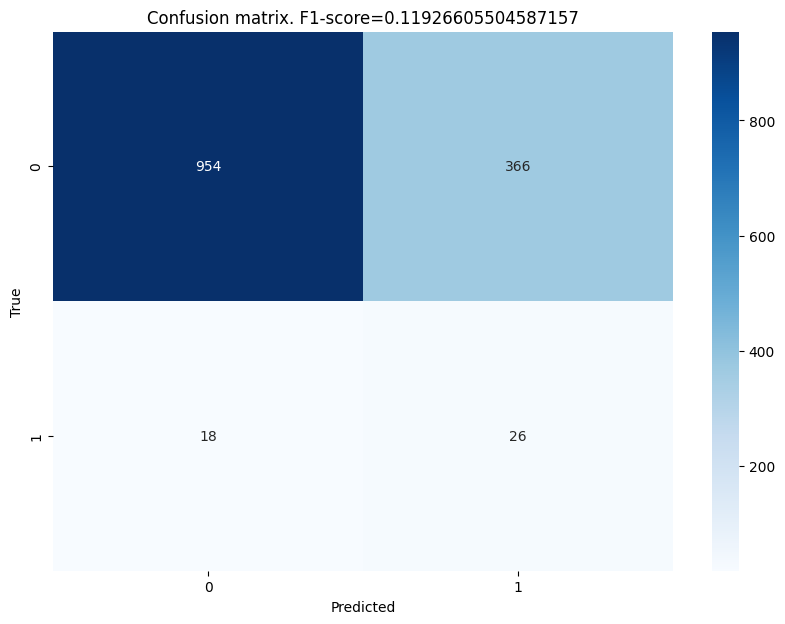

In [79]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_f1_test_knn)

## Comparación de resultados - Prueba

In [80]:
modelos = ['Regresion Lineal', 'Arbol de decision', 'Bosque aleaotorio', 'Gradient Boosting', 'KNN']
f1_test = [test_f1_lr, test_f1_dt, test_f1_rf, test_f1_gb, test_f1_knn]
umbrales = [best_threshold_lr, best_threshold_dt, best_threshold_rf, best_threshold_gb, best_threshold_knn]
f1_ajustada_test = [adjusted_f1_test_lr, adjusted_f1_test_dt, adjusted_f1_test_rf, adjusted_f1_test_gb, adjusted_f1_test_knn]
auc_test = [auc_score_test_lr, auc_score_test_dt, auc_score_test_rf, auc_score_test_gb, auc_score__test_knn]

prueba_comparativa = pd.DataFrame({
    'Modelo': modelos,
    'F1': f1_test,
    'Umbral': umbrales,
    'F1 Ajustado': f1_ajustada_test,
    'AUC': auc_test
})

prueba_comparativa


,Modelo,F1,Umbral,F1 Ajustado,AUC
0,Regresion Lineal,0.000000,0.420691,0.069257,0.483049
1,Arbol de decision,0.336735,0.779661,0.361290,0.836054
2,Bosque aleaotorio,0.395210,0.600909,0.394161,0.939885
3,Gradient Boosting,0.455172,0.697162,0.453125,0.941615
4,KNN,0.095764,0.555556,0.119266,0.710778


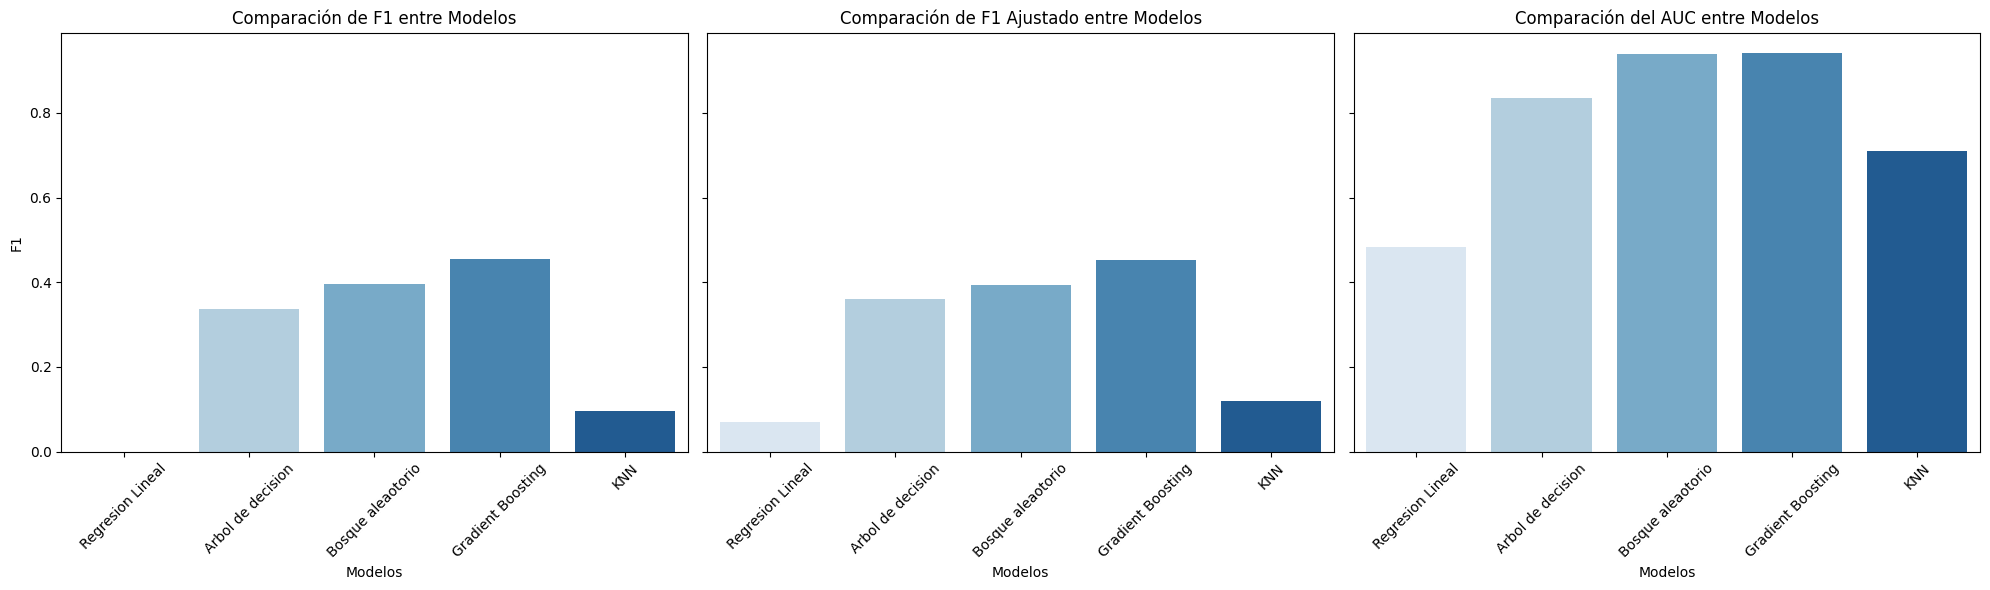

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Comparacion de la precisión en los datos de validacion
sns.barplot(ax=axes[0], x='Modelo', y='F1', hue='Modelo', data=prueba_comparativa, palette='Blues')
axes[0].set_title('Comparación de F1 entre Modelos')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('F1')
axes[0].tick_params(axis='x', rotation=45)

# Comparacion de la precisión ajustada en los datos validacion
sns.barplot(ax=axes[1], x='Modelo', y='F1 Ajustado', hue='Modelo', data=prueba_comparativa, palette='Blues')
axes[1].set_title('Comparación de F1 Ajustado entre Modelos')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('F1 Ajustado')
axes[1].tick_params(axis='x', rotation=45)

# Comparacion del AUC score en los datos de validacion
sns.barplot(ax=axes[2], x='Modelo', y='AUC', hue='Modelo',data=prueba_comparativa, palette='Blues')
axes[2].set_title('Comparación del AUC entre Modelos')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('AUC')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Comparación: Validación - Prueba

In [82]:
print('En datos de Validación')
print(validacion_comparativa)
print('''
      -----------------------------------------------------------------------------------------------------
      ''')
print('En datos de Prueba')
print(prueba_comparativa)

En datos de Validación
              Modelo        F1    Umbral  F1 Ajustado       AUC
0   Regresion Lineal  0.000000  0.420691     0.069490  0.432238
1  Arbol de decision  0.311377  0.779661     0.330709  0.857305
2  Bosque aleaotorio  0.391304  0.600909     0.407407  0.931602
3  Gradient Boosting  0.410714  0.697162     0.424242  0.919968
4                KNN  0.138462  0.555556     0.114478  0.736161

      -----------------------------------------------------------------------------------------------------
      
En datos de Prueba
              Modelo        F1    Umbral  F1 Ajustado       AUC
0   Regresion Lineal  0.000000  0.420691     0.069257  0.483049
1  Arbol de decision  0.336735  0.779661     0.361290  0.836054
2  Bosque aleaotorio  0.395210  0.600909     0.394161  0.939885
3  Gradient Boosting  0.455172  0.697162     0.453125  0.941615
4                KNN  0.095764  0.555556     0.119266  0.710778


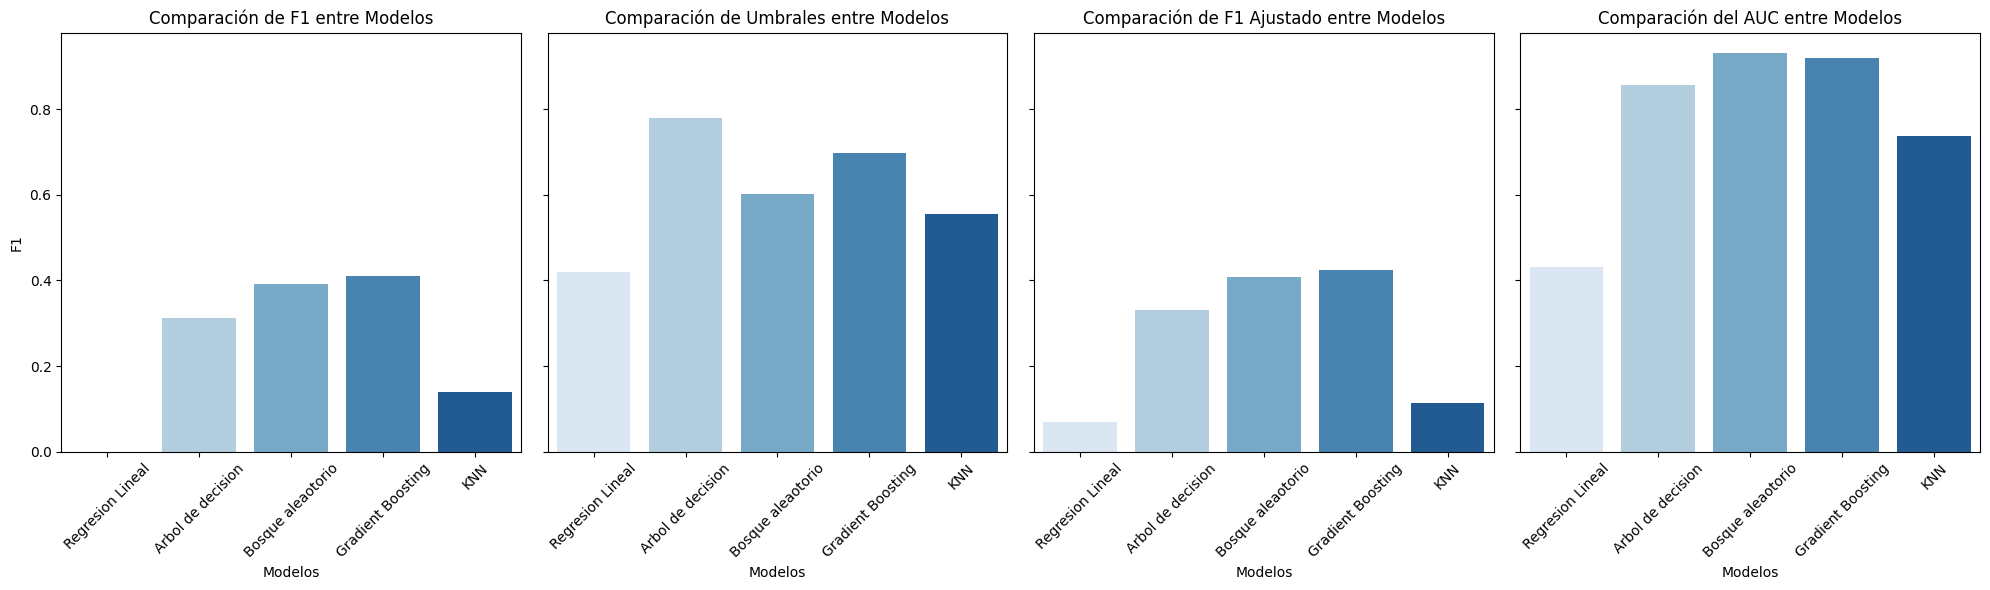

In [83]:
# Datos de validación
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

# Comparacion de la precisión en los datos de validacion
sns.barplot(ax=axes[0], x='Modelo', y='F1', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[0].set_title('Comparación de F1 entre Modelos')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('F1')
axes[0].tick_params(axis='x', rotation=45)

# Comparacion de umbrales optimos
sns.barplot(ax=axes[1], x='Modelo', y='Umbral', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[1].set_title('Comparación de Umbrales entre Modelos')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Umbral')
axes[1].tick_params(axis='x', rotation=45)

# Comparacion de la precisión ajustada en los datos validacion
sns.barplot(ax=axes[2], x='Modelo', y='F1 Ajustado', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[2].set_title('Comparación de F1 Ajustado entre Modelos')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('F1 Ajustado')
axes[2].tick_params(axis='x', rotation=45)

# Comparacion del AUC score en los datos de validacion
sns.barplot(ax=axes[3], x='Modelo', y='AUC', hue='Modelo',data=validacion_comparativa, palette='Blues')
axes[3].set_title('Comparación del AUC entre Modelos')
axes[3].set_xlabel('Modelos')
axes[3].set_ylabel('AUC')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

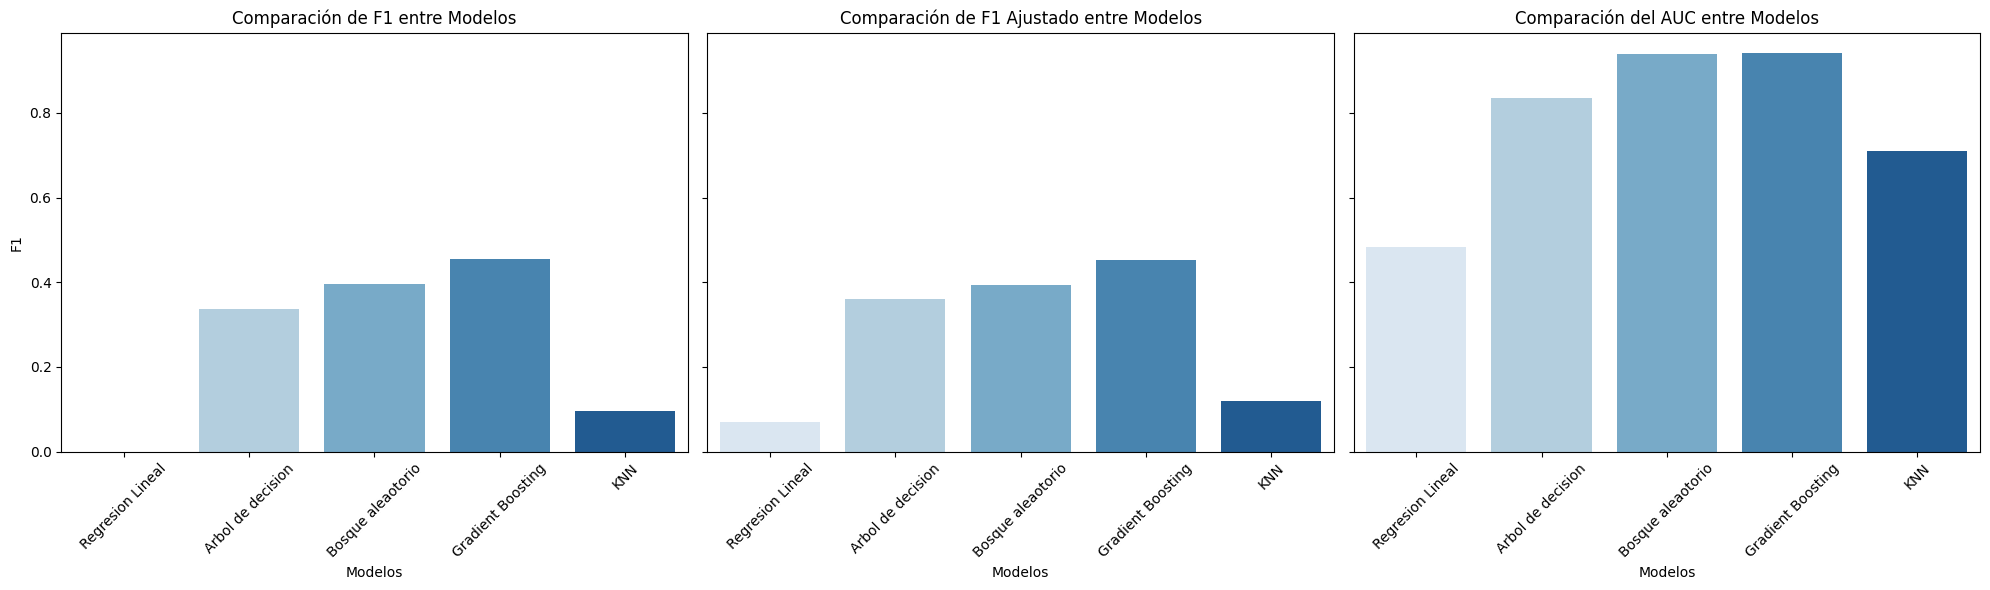

In [84]:
# Datos de prueba
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Comparacion de la precisión en los datos de validacion
sns.barplot(ax=axes[0], x='Modelo', y='F1', hue='Modelo', data=prueba_comparativa, palette='Blues')
axes[0].set_title('Comparación de F1 entre Modelos')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('F1')
axes[0].tick_params(axis='x', rotation=45)

# Comparacion de la precisión ajustada en los datos validacion
sns.barplot(ax=axes[1], x='Modelo', y='F1 Ajustado', hue='Modelo', data=prueba_comparativa, palette='Blues')
axes[1].set_title('Comparación de F1 Ajustado entre Modelos')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('F1 Ajustado')
axes[1].tick_params(axis='x', rotation=45)

# Comparacion del AUC score en los datos de validacion
sns.barplot(ax=axes[2], x='Modelo', y='AUC', hue='Modelo',data=prueba_comparativa, palette='Blues')
axes[2].set_title('Comparación del AUC entre Modelos')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('AUC')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()